<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Train-from-specified-config-files" data-toc-modified-id="Train-from-specified-config-files-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Train from specified config files</a></span><ul class="toc-item"><li><span><a href="#Build-model" data-toc-modified-id="Build-model-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Build model</a></span></li><li><span><a href="#Augment-data" data-toc-modified-id="Augment-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Augment data</a></span></li><li><span><a href="#Auxiliary-train-time-functions" data-toc-modified-id="Auxiliary-train-time-functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Auxiliary train time functions</a></span></li><li><span><a href="#Training-functions" data-toc-modified-id="Training-functions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Training functions</a></span></li><li><span><a href="#Unifying-Function" data-toc-modified-id="Unifying-Function-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Unifying Function</a></span></li><li><span><a href="#Run-training" data-toc-modified-id="Run-training-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Run training</a></span></li></ul></li></ul></div>

# Train from specified config files
        -- Built for any deepfakes dataset with file structure as follows:

In [ ]:
!pip install git+https://github.com/qubvel/efficientnet
!pip install imgaug

In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras import Model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os
import glob
import cv2
import TransformCode as tc
from io import BytesIO
from PIL import Image
from numpy import expand_dims
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import *
import warnings
import logging
from IPython.display import clear_output
from collections import Counter
import pickle
import json
import sys
sys.path.insert(1, '/home/jupyter/DeepFake-2019-20/augmentations')
sys.path.insert(1, '/home/jupyter/DeepFake-2019-20/hyperparameters')
sys.path.insert(1, '/home/jupyter/DeepFake-2019-20/visualisations')
import VisualisationTools as plotting
import hyper_utils as hp
import custom_aug as deepaug


warnings.filterwarnings("ignore")
logger = logging.getLogger()
logger.setLevel(100)
plot_losses = plotting.PlotLearning()
os.chdir('/home/jupyter/DeepFake-2019-20')

# # Augmentation libraries
# import face_recognition
# import cutout_augmentation as ca

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0-dlenv


In [2]:
# Specify config file
config_number=1020
config_file='config{}'.format(config_number)
def obtain_configs(number):
    '''Extracts hyperparameters from config file given the config file number.'''
    with open('../configs/config{}.json'.format(number)) as f:
        params = json.load(f)

    return params

params = obtain_configs(config_number)
params

{'architecture': 'lstm',
 'epochs': 50,
 'batch_size': 4,
 'learning_rate_type': 'constant',
 'learning_rate': 0.0001,
 'patience': 10,
 'weight_initialisation': 'imagenet',
 'optimiser': 'adam',
 'momentum': 0.99,
 'nesterov': 'False',
 'label_smoothing': 0.01,
 'dropout': 0.5,
 'target_size': 224,
 'class_weights': 'True',
 'warmup_epochs': 0}

In [3]:
import VideoFrameGenerator

# use sub directories names as classes
classes = [i.split(os.path.sep)[-1] for i in glob.glob('../restructured-all-faces/home/jupyter/restructured_data/train/*')]
classes.sort() # actually already within source code
print(classes)

# Global params
SIZE = (224, 224)
CHANNELS = 3
NBFRAME = 20
BS = 8

# Pattern to get videos and classes
glob_pattern_train = '../restructured-all-faces/home/jupyter/restructured_data/train/{classname}/*'
glob_pattern_val = '../restructured-all-faces/home/jupyter/restructured_data/validation/{classname}/*'

# for data augmentation
data_aug_train = tf.keras.preprocessing.image.ImageDataGenerator(
            samplewise_center=True,  # set each sample mean to 0
            samplewise_std_normalization=True,  # divide each input by its std
            rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
            fill_mode='nearest',
            brightness_range=None,
            horizontal_flip=True,  # randomly flip images
            preprocessing_function=deepaug.joint_function,
            data_format=None,)

data_aug_val = tf.keras.preprocessing.image.ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

['authentic', 'fake']


## Build model

In [8]:
def build_model(dropout, lr_rate, architecture = 'lstm',frozen_base = True):
    
    frames = 20
    channels = 3
    rows = 224
    columns = 224
    embed_dim = 1280
    num_heads = 8
    ff_dim = 512
    
    # embed_dim is Embedding size for each token
    # num_heads is number of attention heads
    # ff_dim is hidden layer size in feed forward network inside transformer
    
    video = tf.keras.layers.Input(shape=(frames,
                         rows,
                         columns,
                         channels,))
        
    #from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
    #conv_base = MobileNetV2(weights='imagenet', include_top=False,
    #                    input_shape=(224,224,3))
    
    from efficientnet.tfkeras import EfficientNetB0
    conv_base = EfficientNetB0(weights='noisy-student', include_top=False,
            input_shape=(224,224,3))
    cnn_out = GlobalAveragePooling2D()(conv_base.output)
    cnn = tf.keras.Model(inputs=conv_base.input, outputs=cnn_out)
    #cnn.trainable = False
    
    encoded_frames = tf.keras.layers.TimeDistributed(cnn)(video)
        
    if architecture == 'lstm':
        
        encoded_sequence = tf.keras.layers.LSTM(2048, dropout = dropout)(encoded_frames)
        hidden_layer = tf.keras.layers.Dense(512, activation="relu")(encoded_sequence)
        hidden_layer2 = tf.keras.layers.Dense(128, activation="relu")(hidden_layer)
        dropoutlstm = tf.keras.layers.Dropout(dropout)(hidden_layer2)
        outputs = tf.keras.layers.Dense(2, activation="softmax")(dropoutlstm)
        model = Model([video], outputs)
    
        
    if architecture == 'transformer':
        
        transformer_block1 = tc.TransformerBlock(embed_dim, num_heads, ff_dim)
        x = transformer_block1(encoded_frames)
        transformer_block2 = tc.TransformerBlock(embed_dim, num_heads, ff_dim)
        x = transformer_block2(x)
        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.Dense(512, activation="relu")(x)
        x = tf.keras.layers.Dense(128, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout)(x)
        outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
        model = Model([video], outputs)
                
    if frozen_base:
        cnn.trainable = False # freeze the convolutional base
        
    else: 
        cnn.trainable = True    
    
    optimizer = tf.keras.optimizers.Nadam(lr=lr_rate,
                      beta_1=0.9,
                      beta_2=0.999,
                      epsilon=1e-08,
                      schedule_decay=0.004)
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"]) 
    print(model.summary())
    return model

In [9]:
def load_model_weights(model, architecture):
    '''An alternative to training if there are already some generated weights
    
    Takes a built model (and its architecture type) and loads the weights
    with the highest validation accuracy.
    
    If there are no saved weights, a message is printed.'''

    path_to_weights = "../all_faces_bucket/trained_models/weights/{}".format(config_file)
    # get all the weights file names in a list
    if os.path.exists(path_to_weights):
        all_weights = sorted(os.listdir(path_to_weights + '/'))
    # If there is at least one file
        if len(all_weights) >= 1:
            # Use weights from highest val acc
            model.load_weights(path_to_weights + '/' + 'highest_val_acc.hdf5')
            
        else: # otherwise warn that no weights were loaded
            print("There are no weights stored. Training model from scratch:")   
    
    else: # otherwise warn that no weights were loaded
        print("There are no weights stored. Training model from scratch:")   
        
def save_model_from_best_weights(dropout, lr_rate, architecture, frozen_base):
    '''Takes the weights with the highest val accuracy and saves the corresponding model.'''
    model = build_model(dropout, lr_rate, architecture, frozen_base)
    load_model_weights(model, architecture)
    model.save('../all_faces_bucket/trained_models/saved_models/{}.h5'.format(config_file))    

In [10]:
def train_model(model, train_data, val_data, epochs, class_weights, architecture, lr_rate):
    '''Trains a provided model.
    Takes 6 arguments:
    
    1. model: a built model with an architecture specified in the build function
    2. train_data: augmented data obtained from the augment_data function
    3. val_data: validation data obtained from the augment_data function
    4. epochs -- number of epochs
    5. class weights -- a dictionary with weights (equal for balanced data so
    no negative impact)
    6. architecture: can choose vgg, xception, resnet50, mobilenet or efficientnet
    7. lr_rate: initial learning rate
    '''
    
    # Make a trained_models folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models'):
        os.makedirs('../all_faces_bucket/trained_models')
    
    # Make a weights folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/weights'):
        os.makedirs('../all_faces_bucket/trained_models/weights')
        
    # Make a weights folder for the architecture if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/weights/{}'.format(config_file)):
        os.makedirs('../all_faces_bucket/trained_models/weights/{}'.format(config_file))

    # Below saves on file - the weights with the highest validation accuracy
    filepath="../all_faces_bucket/trained_models/weights/{}/highest_val_acc.hdf5".format(config_file)
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                verbose=1, save_best_only=True, mode='max')
    
    # Make a folder to store training accuracies if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/training_accuracies'):
        os.makedirs('../all_faces_bucket/trained_models/training_accuracies')
    
    # Callback to save training accuracies after each epoch
    csv_logger = CSVLogger('../all_faces_bucket/trained_models/training_accuracies/{}.csv'.format(config_file),
                           separator=',', append=True)
    
    # Stop after 3 epochs if val_accuracy doesn't improve
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=params['patience'])
                          
    # Load previous weights from training if there are any
    load_model_weights(model, architecture)
    
    if params['learning_rate_type']=='cosine_decay':
        # Set learning rate config 
        sample_count = train_data.n # number of training samples
        epochs = epochs # total epochs - affects total steps (and hence speed of decay)
        warmup_epoch = params['warmup_epochs'] # number of warmup epochs
        batch_size = train_data.batch_size
        learning_rate_base = lr_rate
        total_steps = int(epochs * sample_count / batch_size)

        warmup_steps = int(warmup_epoch * sample_count / batch_size)

        warm_up_lr = hp.WarmUpCosineDecayScheduler(learning_rate_base=learning_rate_base,
                                            total_steps=total_steps,
                                            warmup_learning_rate=0.0,
                                            warmup_steps=warmup_steps,
                                            hold_base_rate_steps=2,
                                            verbose=0)

        cb = [plot_losses, checkpoint, csv_logger, es, warm_up_lr]
        
    elif params['learning_rate_type']=='constant':
        cb = [plot_losses, checkpoint, csv_logger, es]
        
    elif params['learning_rate_type']=='increasing':
        pass

    history = model.fit(train_data, epochs=epochs,
              validation_data = val_data, 
              class_weight=class_weights,
              callbacks=cb,
              initial_epoch=0,                    # start training epoch - useful if continuing training
              verbose=1,
              max_queue_size=100,                # maximum size for the generator queue
              workers=16,                        # maximum number of processes to spin up when using process-based threading
              use_multiprocessing=False)
    
    # Make a saved models folder if it doesn't exist
    if not os.path.exists('../all_faces_bucket/trained_models/saved_models'):
        os.makedirs('../all_faces_bucket/trained_models/saved_models')
        
    model.save_weights('../all_faces_bucket/trained_models/weights/{}/lastepoch.hdf5'.format(config_file)) 
    model.save('../all_faces_bucket/trained_models/saved_models/{}.h5'.format(config_file))    

In [11]:
def run_training(dropout = 0.5, lr_rate = 0.0001, architecture = 'vgg', 
                 batch = 32, epochs = 50, frozen_base=True):

    '''Builds a model based on the specified architecture, augments training
    data (reserving a fraction for validation), then computes class weights to
    balance data and trains the model.
    
    Inputs:
    1. dropout  -- for the model
    2. lr_rate
    3. architecture -- a choice of vgg, resnet50, mobilenet, xception and efficientnet
    4. batch -- batch size
    5. epochs -- number of epochs
    '''

    # Build a model, augment data, get class_weights and train the model
    # Strategy scope allows us to leverage multiple GPUs
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))
    
    with strategy.scope(): # Allows for parallel GPUs
        model = build_model(dropout, lr_rate, architecture, frozen_base)
    
    # Create video frame generator
    
    train_data = VideoFrameGenerator.VideoFrameGenerator(
        classes=classes, 
        glob_pattern=glob_pattern_train,
        nb_frames=NBFRAME,
        shuffle=True,
        batch_size=batch,
        target_shape=SIZE,
        nb_channel=CHANNELS,
        transformation=data_aug_train)
    
    val_data = VideoFrameGenerator.VideoFrameGenerator(
        classes=classes, 
        glob_pattern=glob_pattern_val,
        nb_frames=NBFRAME,
        shuffle=True,
        batch_size=batch,
        target_shape=SIZE,
        nb_channel=CHANNELS,
        transformation=data_aug_val)
    
    class_weights = {0: 4, 1: 1}
    
    if params['class_weights']=='True':
        trained_model = train_model(model, train_data, val_data, epochs, class_weights, architecture, lr_rate)
    else:
        trained_model = train_model(model, train_data, val_data, epochs, None, architecture, lr_rate)

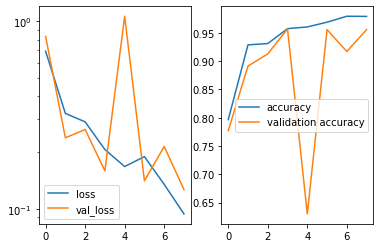


Epoch 00008: val_accuracy did not improve from 0.95714
900/900 [==============================] - 509s 566ms/step - accuracy: 0.9792 - loss: 0.0940 - val_accuracy: 0.9557 - val_loss: 0.1268
Epoch 9/50
410/900 [============>.................] - ETA: 4:07 - accuracy: 0.9768 - loss: 0.1543

In [ ]:
run_training(dropout = params['dropout'], lr_rate = params['learning_rate'], 
             architecture = params['architecture'], batch = params['batch_size'],
             epochs = params['epochs'], frozen_base=False)

In [ ]:
# Save model to bucket from highest val acc weights
save_model_from_best_weights(dropout = 0.3, lr_rate = 0.0001, architecture = 'transformer', frozen_base=False)